In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# LSTM Model
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
data_path = os.path.join(os.getcwd(), 'data')
data_path

'C:\\Users\\lynkx\\Python Projects\\BB\\data'

In [4]:
df_kpis = pd.read_excel(os.path.join(data_path, 'analisi.xlsx'), sheetname='KPIs')
df_spending = pd.read_excel(os.path.join(data_path, 'analisi.xlsx'), sheetname='Spending')

In [5]:
df_kpis.sort_values(by='Date', inplace=True)
df_spending.sort_values(by='Date', inplace=True)

# Drop K5, because it's another response variable
df_kpis.drop('K5', axis=1, inplace=True)

In [6]:
# Date metric
df_kpis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932 entries, 0 to 931
Data columns (total 11 columns):
Date    932 non-null datetime64[ns]
K1      932 non-null int64
K2      932 non-null int64
K3      932 non-null int64
K4      932 non-null int64
K6      932 non-null int64
K7      932 non-null int64
K8      932 non-null int64
K9      932 non-null float64
K10     932 non-null float64
K11     932 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 87.4 KB


In [7]:
df_kpis['month'] = df_kpis['Date'].dt.month
df_kpis['year'] = df_kpis['Date'].dt.year
df_kpis['weekday'] = df_kpis['Date'].dt.weekday
df_kpis['days_in_month'] = df_kpis['Date'].dt.daysinmonth

In [8]:
df_kpis_date = df_kpis['Date']
df_kpis.index = df_kpis_date
df_kpis.drop('Date', axis=1, inplace=True)

In [9]:
df_kpis.head()

,K1,K2,K3,K4,K6,K7,K8,K9,K10,K11,month,year,weekday,days_in_month
Date,,,,,,,,,,,,,,
2015-03-16,0,0,155,0,379,195,923,3.030303,0.210184,0.333333,3,2015,0,31
2015-03-17,1,8,1074,34,658,468,3563,4.532667,0.370474,0.301205,3,2015,1,31
2015-03-18,0,10,1129,46,652,493,3679,4.902364,0.366676,0.288462,3,2015,2,31
2015-03-19,0,7,1107,33,597,522,3517,4.775744,0.355701,0.385714,3,2015,3,31
2015-03-20,0,13,1116,143,606,453,3815,4.228381,0.388991,0.678571,3,2015,4,31


In [10]:
df_spending['month'] = df_spending['Date'].dt.month
df_spending['year'] = df_spending['Date'].dt.year
df_spending['days_in_month'] = df_spending['Date'].dt.daysinmonth
df_spending.index = df_spending['Date']
df_spending.drop('Date', axis=1, inplace=True)

In [11]:
df_spending['avgE1'] = df_spending['E1']/df_spending['days_in_month']
df_spending['avgE2'] = df_spending['E2']/df_spending['days_in_month']

In [12]:
df_kpis = df_kpis.merge(df_spending[['year', 'month', 'avgE1', 'avgE2']], on=['year', 'month'],
                        how='inner')
df_kpis.index = df_kpis_date

In [13]:
df_kpis.head()

,K1,K2,K3,K4,K6,K7,K8,K9,K10,K11,month,year,weekday,days_in_month,avgE1,avgE2
Date,,,,,,,,,,,,,,,,
2015-03-16,0,0,155,0,379,195,923,3.030303,0.210184,0.333333,3,2015,0,31,530.129032,4403.387097
2015-03-17,1,8,1074,34,658,468,3563,4.532667,0.370474,0.301205,3,2015,1,31,530.129032,4403.387097
2015-03-18,0,10,1129,46,652,493,3679,4.902364,0.366676,0.288462,3,2015,2,31,530.129032,4403.387097
2015-03-19,0,7,1107,33,597,522,3517,4.775744,0.355701,0.385714,3,2015,3,31,530.129032,4403.387097
2015-03-20,0,13,1116,143,606,453,3815,4.228381,0.388991,0.678571,3,2015,4,31,530.129032,4403.387097


In [14]:
df_kpis.shape

(932, 16)

In [15]:
cols_list = [i for i in df_kpis.columns if i[0] == 'K']
cols_list.append('avgE1')
cols_list.append('avgE2')

In [16]:
print(cols_list)

['K1', 'K2', 'K3', 'K4', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'avgE1', 'avgE2']


In [17]:
logs = np.log1p(df_kpis[cols_list])
logs.head()

,K1,K2,K3,K4,K6,K7,K8,K9,K10,K11,avgE1,avgE2
Date,,,,,,,,,,,,
2015-03-16,0.000000,0.000000,5.049856,0.000000,5.940171,5.278115,6.828712,1.393842,0.190773,0.287682,6.275005,8.390356
2015-03-17,0.693147,2.197225,6.980076,3.555348,6.490724,6.150603,8.178639,1.710670,0.315157,0.263291,6.275005,8.390356
2015-03-18,0.000000,2.397895,7.029973,3.850148,6.481577,6.202536,8.210668,1.775353,0.312381,0.253449,6.275005,8.390356
2015-03-19,0.000000,2.079442,7.010312,3.526361,6.393591,6.259581,8.165648,1.753667,0.304319,0.326216,6.275005,8.390356
2015-03-20,0.000000,2.639057,7.018402,4.969813,6.408529,6.118097,8.246958,1.654102,0.328577,0.517943,6.275005,8.390356


In [18]:
dummies = pd.get_dummies(df_kpis[['month', 'weekday']].astype(str))
dummies.head()

,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Date,,,,,,,,,,,,,,,,,,,
2015-03-16,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2015-03-17,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2015-03-18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2015-03-19,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2015-03-20,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [19]:
df = pd.concat([logs, dummies], axis=1)
print(df.shape)
print(df.columns)

(932, 31)
Index(['K1', 'K2', 'K3', 'K4', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'avgE1',
       'avgE2', 'month_1', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')


In [20]:
np.correlate(df['K11'], df['K9'])

array([ 433.72103124])

In [21]:
from scipy.signal import correlate
correlate(df['K11'], df['K9'])

array([ 0.51744952,  0.96245946,  1.42100035, ...,  0.50421893,
        0.34533968,  0.16656622])

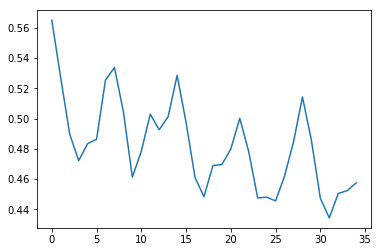

In [24]:
from statsmodels.tsa.stattools import ccf
plt.plot(ccf(df['K11'], df['K9'])[0:35])

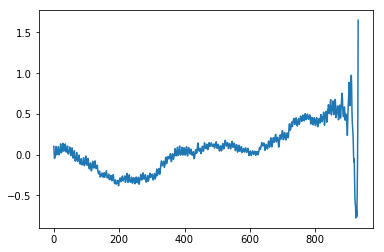

In [28]:
plt.plot(ccf(df['K11'], df['K7']))

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['K11'].values)

In [ ]:
df.iloc[7:10]['K11']

In [ ]:
n = df.shape[0]
mylag = 7
k_last = df.iloc[(mylag - 1):n]['K11']
k_first = df.iloc[0:(n - mylag)]['K11']
k_diff = k_last.reset_index() - k_first.reset_index()
# k_diff.drop('index', axis=1, inplace=True)

In [ ]:
k_diff.drop(k_diff[k_diff['K11'].isnull() == True].index, axis=0, inplace=True )

In [ ]:
adfuller(k_diff['K11'].values)

In [ ]:
k_diff['K11'].isnull() == True